# Demo of using ANN and Keras for Churn Prediction

In [1]:
import pandas as pd

In [2]:
churndf = pd.read_csv("./Data/Churn_Modelling.csv")  
churndf   #Preliminary view of dataframe

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [3]:
list(churndf)[3:]

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

### Statistical summary of the data.

In [4]:
#Separate into data and target
X = churndf.iloc[:,3:-1] #Skip the first three metadata columns and the last target column.
y = churndf.iloc[:,-1:]
X.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


## Notes for Data Preparation

- Of all the features the clearly continuous features are: **_CreditScore, Age, Balance, EstimatedSalary_**.
- The clearly categorical features are: **_Geography, Gender, HasCrCard, IsActiveMember_**
- Of the remaining:
    - **Tenure**. Has discrete values with min/max of 0/10. We can treat it as **categorical**.
    - **NumOfProducts**: Has discrete values with min/max of 1/4. It can be treated as **categorical**.
    
We will encode the Categorical features and scale the Continuous features. Multilabel categorical features will bave to be OneHotEncoded. Continuous features need to be scaled either using minmax scaling or standard scaling depending on the distribution of the feature. 

## Data Exploration

To understand the features better, let us do some basic data exploration. 

We can see some clear trends. 
- Categorical features tend to get arranged in neat rows or columns. This confirms our initial tagging of features as categorical.
- Of the Continuous features, CreditScore, Age and Balance have a Gaussian/Normal Distribution. (Requires standard scaling.)
- Quite counter-intuitively, EstimatedSalary has a uniform distribution.(Requires minmax scaling)

Some other interesting trends are:
- People in the 40-60 age group tend to churn more across all features.
- People with three or four products also tend to churn across all features.


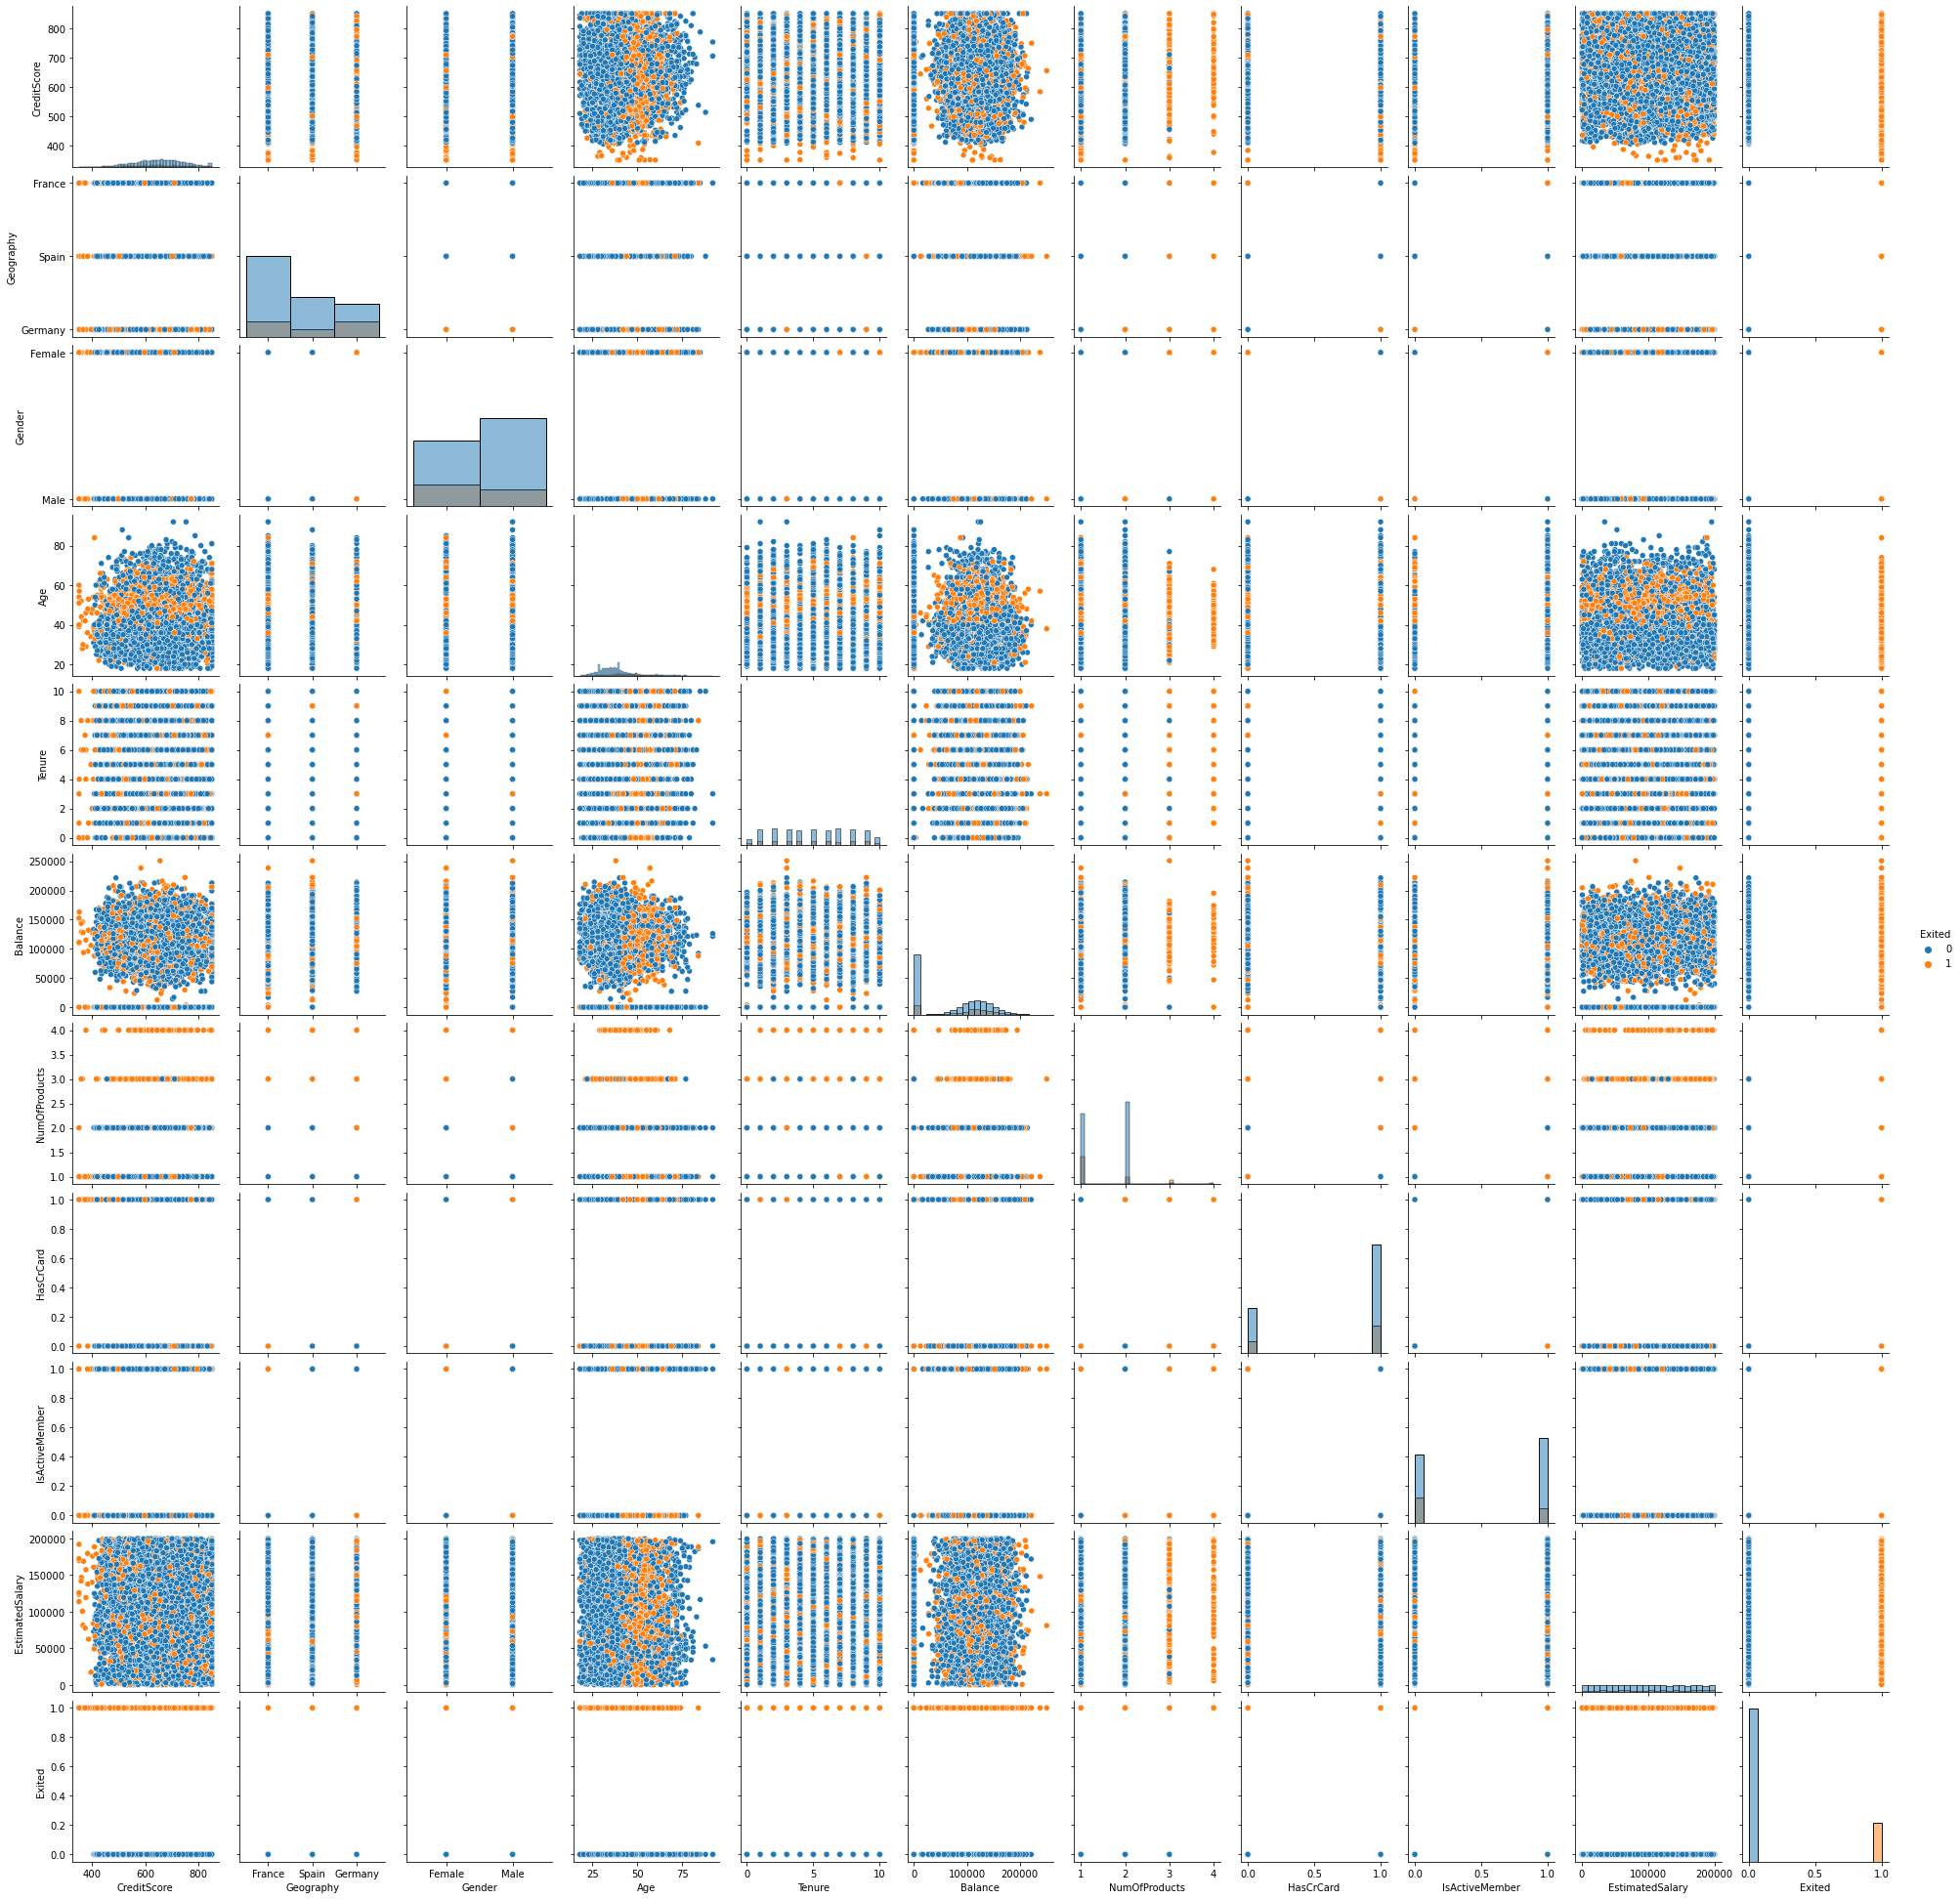

In [5]:
import seaborn as sns
sns.pairplot(churndf.iloc[:,3:],vars = list(churndf)[3:], hue='Exited',diag_kind="hist",corner=False)
#Plot all variables except the first three metadata columns

## Feature encoding and scaling
We will use the sklearn ColumnTransformer to do our encoding and scaling.

In [6]:
#Split our data into training and test set.
#The earlier pairplot shows us an imbalance in the dataset on the features of Geography, 
#Gender,NumOfProducts and HasCrCard. We therefore stratify on these features.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1,
                stratify = X[['Geography','Gender','NumOfProducts','HasCrCard']])
                #stratify=y)   #Stratify on target label. Or on X attributes as below.
X_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
4976,828,Germany,Female,25,7,144351.86,1,1,0,116613.26
1904,625,Spain,Female,69,1,107569.96,1,1,1,182336.45
9329,663,Spain,Male,35,5,0.00,2,1,1,62634.94
1000,648,Germany,Female,42,8,121980.56,2,1,0,4027.02
1640,583,Spain,Male,47,5,102562.23,1,1,0,92708.10
...,...,...,...,...,...,...,...,...,...,...
9169,766,France,Female,45,6,0.00,2,0,0,147184.74
8965,477,Germany,Female,58,8,145984.92,1,1,1,24564.70
546,587,France,Male,38,0,0.00,2,1,0,47414.15
7112,670,Germany,Female,35,2,79585.96,1,0,1,198802.90


In [7]:
#Create the column transformer
#Summary: CreditScore, Age, Balance -- StandardScaler
#         EstimatedSalary -- MinMaxScaler
#         Gender - OrdinalEncoder. HasCrCard, IsActiveMember are already encoded
#         Geography, Tenure, NumOfProducts - OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing as prep

colxformer = ColumnTransformer([
    ('standard',prep.StandardScaler(),['CreditScore','Age','Balance']),
    ('minmax',prep.MinMaxScaler(),['EstimatedSalary']),
    ('onehot',prep.OneHotEncoder(),['Geography','Tenure','NumOfProducts']),
    ('labelenc',prep.OrdinalEncoder(),['Gender'])
    ],
    remainder='passthrough')

In [8]:
#We fit the training set to the transformer and then transform both training and test set.
colxformer.fit(X_train)

#Now we have a trained column transformer. We need to pickle this as well to deploy our model separately.
import pickle
pickle.dump(colxformer,open("colxformer.pkl","wb"))

#Now transform both the training and the test data.
X_train_es = pd.DataFrame(colxformer.transform(X_train)) # _es stands for encoded scaled
X_test_es = pd.DataFrame(colxformer.transform(X_test))
#y_test and y_train are already binary encoded and don't need transformation
X_train_es
X_test_es

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-1.260149,-1.613636,-1.230648,0.520844,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-1.405747,0.103543,-1.230648,0.166289,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.580621,-0.850445,-1.230648,0.165755,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.175028,-1.041243,0.484588,0.965128,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.965415,0.198942,0.115932,0.987780,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,0.143828,-1.041243,1.833540,0.416174,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3296,0.549422,0.866734,1.458843,0.867517,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
3297,-0.636159,-0.182653,-0.200539,0.308768,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3298,0.944615,-0.373451,0.036091,0.634990,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


## Creating the ANN
Having encoded and scaled the data we will create our neural network. It needs 25 inputs which is also the number of scaled/encoded columns. We need one output to predict 1 or 0 for churn. 

We created an ANN of 25/35/25/1 i.e input of 25, two hidden layers of 35 and 25 and output layer of 1.
Later we settled for 25/10/1 to guard against overfitting.

In [9]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(10, input_dim=25, activation='relu')) #First hidden layer of 10 with input of 25
model.add(Dense(1, activation='sigmoid'))  #Output Layer
#Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

2021-08-30 12:42:20.648069: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-30 12:42:20.671583: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-30 12:42:20.727201: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
import matplotlib.pyplot as plt
#Now we fit the model on our training set
n_epochs = 20
history = model.fit(X_train_es, y_train, validation_split = 0.33, epochs=n_epochs, batch_size=4, verbose = 0)

#We will save the model for independent deployment
model.save('./churn_ann_model.h5')

2021-08-30 12:42:21.707980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-30 12:42:21.841572: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2494370000 Hz


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


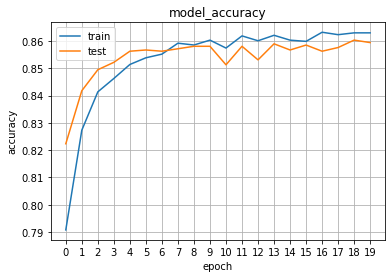

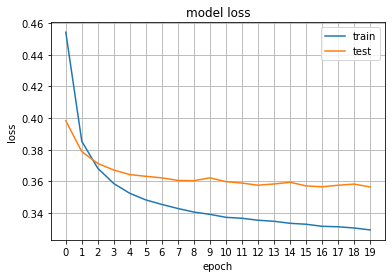

In [11]:
#The model tends to overfit after about 10 epochs. See graph below.
#Use verbose=0 if you get error in JupyterNotebook
print(history.history.keys())
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.axis([0,n_epochs,0,1])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([float(i) for i in range(0,n_epochs,1)])
plt.legend(['train','test'],loc = 'best')
plt.grid()
plt.show()
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.axis([0,n_epochs,0,1])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks([float(i) for i in range(0,n_epochs,1)])
plt.legend(['train','test'],loc = 'best')
plt.grid()
plt.show()

In [12]:
_,accuracy = model.evaluate(X_test_es, y_test)

104/104 [==============================] - 1s 6ms/step - loss: 0.3492 - accuracy: 0.8548


In [13]:
print('accuracy = %.2f'%(accuracy*100))

accuracy = 85.48


## Observations

**Initial observations** 

We observe that validation accuracy hovers around 80%.  Increasing the epochs from 20 to 150 does not show any marked change. Evaluating the loss curve of the model for the 25/35/25/1 configuration we observe:
- Large gap between training and validation loss indicating unrepresentative training dataset.
- Divergence of the curves indicating underfitting due to under-capacity.(?)
- Flat training loss curve indicating that the model is unable to learn from the training data again pointing to an underfit.(?)

### Improvement strategy

1. Do a stratified train-test-split on data attributes like 'Geography','Gender','NumOfProducts','HasCrCard' to improve the representation of training and validation datasets.
>- The change is distinct and observable. After about ten epochs, the validation loss increases indicating an overfit. Stratifying on y gives similar results.

2. Finally, we stratified the input data on the target label y. We reduced the complexity of the ANN to 25/10/1 with no degradation in performance. We got a consistent accuracy of about 85%.

## Predicting Churn
Now that we have an accuracy of 85% measured through cross validation of training data, let us take some test data that we have kept aside from the original training set and plot a confusion matrix. We will then know how well our model does with test data.

In [14]:
# We already have X_test_es as the encoded and scaled test set. We will use it for the prediction.
#yhat = model.predict(X_test_es) to predict probability of churn
threshold = 0.5
yhat = (model.predict(X_test_es)>threshold).astype("int32")
#For sigmoid activation, probability of >0.5 signifies churn or value of 1.
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, yhat) #y_true is y_test and y_pred is yhat
print(cm)
tn, fp, fn, tp  = confusion_matrix(y_test,yhat).ravel()
print("\nConfusion matrix Wikipedia style....")
'''
TP FN
FP TN
'''
print("%d %d" %(tp,fn))
print("%d %d" %(fp,tn))
print("Accuracy score: ", accuracy_score(y_test,yhat))

[[2512   99]
 [ 380  309]]

Confusion matrix Wikipedia style....
309 380
99 2512
Accuracy score:  0.8548484848484849


## ROC Curve

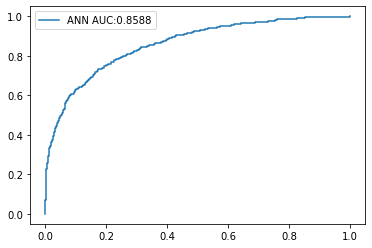

In [15]:
from sklearn.metrics import roc_curve,auc

pred_probs = model.predict(X_test_es) #Prediction probabilities of positive case. Since this is not a binary classifier
# we get just one column of probabilities. For a classifier we would use .predict_proba()

fpr,tpr,_ = roc_curve(y_test,pred_probs)
# roc_curve -- the second argument is prediction probability of positive case or churn.
roc_auc = auc(fpr,tpr)
label_str = "ANN AUC:%.4f" %  (roc_auc)
plt.plot(fpr,tpr, label=label_str)
plt.legend(loc = 'best')

## Precision-Recall Curve

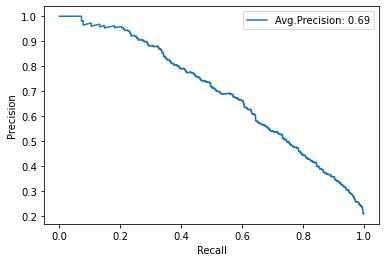

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision_ann, recall_ann, _ = precision_recall_curve(y_test, pred_probs)
label_str = "Avg.Precision: %.2f" % average_precision_score(y_test,pred_probs)
plt.plot(recall_ann, precision_ann, label=label_str)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

## Concluding comments

While we see an accuracy of around 85% it is important to further drill down into the classification details. Plotting a confusion matrix shows us a very low(perhaps unsatisfactory) TPR of 50%. This means we are able to catch only 50% of the customers who churn. Increasing the depth or the width of the layers only leads to overfitting without any appreciable improvement in accuracy or TPR.

### The tradeoff

Decreasing the classification threshold improves our TPR at the expense of accuracy and TNR. So, people should choose what is important for them.